In [285]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from scipy import stats
from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.cross_validation import cross_val_predict
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cross_validation import KFold
# from sklearn.model_selection import train_test_split
%matplotlib inline
%precision %.2f

u'%.2f'

## Load, join, and clean data ##

In [417]:
#ProPublica data from here https://projects.propublica.org/colleges
#Not used in this analysis - but maybe would be better?

pp=pd.read_csv("ProPublica_Data.csv")
pp.head()

,State,Percentage of Pell Grantees,Median Federal Debt for All Students,Median Federal Debt of Pell Grantees,Nonrepayment Rate for Pell Students,Nonrepayment Rate for All Students,"Average Cost for Low-Income Students, Per Year",Default Rate for All Students,"Percentage of All Students Earning $25K or Less Per Year, 10 Years After Enrolling"
0,Adelphi University,0.31,"25,000.00","23,000.00",0.36,0.30,"22,197.00",0.03,0.20
1,Alliant International University-San Diego,0.12,"3,000.00","13,425.00",0.63,0.50,"16,785.00",0.03,0.20
2,American International College,0.51,"27,000.00","21,750.00",0.59,0.52,"17,160.00",0.06,0.26
3,American University,0.17,"24,589.00","25,000.00",0.27,0.20,"28,524.00",0.02,0.17
4,Andrews University,0.29,"27,750.00","26,768.00",0.54,0.49,"19,226.00",0.05,0.34


In [287]:
usnews = pd.read_csv("USNewsCollegeRankings2018.csv")
usnews.set_index('University', inplace=True)
usnews.head()

,City,State,Rank,In-state Tuition,Out-state Tuition,Enrollment
University,,,,,,
Princeton University,Princeton,NJ,1,$47140,$47140,5400.0
Harvard University,Cambridge,MA,2,$48949,$48949,6710.0
University of Chicago,Chicago,IL,3,$54825,$54825,5941.0
Yale University,New Haven,CT,3,$51400,$51400,5472.0
Columbia University,New York,NY,5,$57208,$57208,6113.0


In [288]:
scorecard = pd.read_csv("MERGED2015_16_PP.csv")
scorecard.shape

(7593, 1777)

In [289]:
usnews=usnews[usnews['Rank']!= 'Rank Not Published']
usnews=usnews[usnews['Rank']!= 'Unranked']
usnews.shape

(230, 6)

In [290]:
drop=['\xef\xbb\xbfUNITID','OPEID','OPEID6','CITY','STABBR','ZIP','ACCREDAGENCY','INSTURL','NPCURL']
scorecard.drop(drop, axis=1, inplace=True)
scorecard.set_index('INSTNM',inplace=True)
scorecard = scorecard.loc[usnews.index]
scorecard['Rank']=usnews['Rank']
scorecard.shape

(230, 1768)

In [291]:
# scorecard.dropna(axis=1,thresh=100).shape
data = scorecard.dropna(thresh=100, axis=1).dropna(thresh=500)
for c in data.columns.values:
    data[c] = pd.to_numeric(data[c], errors='coerce')
data.dropna(axis=1,thresh=100, inplace=True)
# data.fillna(data.mean, inplace=True)
cols=[]
for c in data.columns.values:
    if data[c].var()!=0:
       cols.append(c)
data=data[cols]
data.shape

(142, 441)

In [292]:
def normalize(df):
    return(df - df.mean()) / df.std()

scnorm = normalize(data)

## Feature Analysis ##

In [293]:
#Find features that are correlated
# names = pd.read_csv('col_names.csv')

#Remember that rankings are inverted - #1 best

pos_corr_features = []
neg_corr_features = []

for c in data.columns.values:
    corr, p = stats.pearsonr(data[c], data['Rank'])
    if p <0.05 and corr > 0.6 :
        pos_corr_features.append([names[names['VARIABLE NAME']==c]['developer-friendly name'].max(),c, corr,p])

for c in data.columns.values:
    corr, p = stats.pearsonr(data[c], data['Rank'])
    if p <0.05 and corr <-0.6 :
        neg_corr_features.append([names[names['VARIABLE NAME']==c]['developer-friendly name'].max(),c, corr,p])

print "Negatively correlated features"
print
for i in neg_corr_features:
    print i
print
print "Positively correlated features"
print
for i in pos_corr_features:
    print i


Negatively correlated features

['attendance.academic_year', 'COSTT4_A', -0.69324276623784353, 1.1747684869920824e-21]
['tuition.in_state', 'TUITIONFEE_IN', -0.6708655538227406, 6.6045439287982783e-20]
['tuition.out_of_state', 'TUITIONFEE_OUT', -0.80388132647381072, 2.1484910350060433e-33]
['tuition_revenue_per_fte', 'TUITFTE', -0.6832112699637477, 7.4765807627162871e-21]
['instructional_expenditure_per_fte', 'INEXPFTE', -0.65204708927174659, 1.5058505552534478e-18]
['faculty_salary', 'AVGFACSAL', -0.79947180469420553, 8.6302161050122247e-33]
['completion_rate_4yr_150nt', 'C150_4', -0.93914484934669773, 7.7355498448246544e-67]
['completion_rate_4yr_150nt_pooled', 'C150_4_POOLED', -0.94029211271902291, 2.1249830406631032e-67]
['share_first.time_full.time', 'PFTFTUG1_EF', -0.72124435609264526, 4.3840422394709534e-24]
['completion_rate_4yr_150_black', 'C150_4_BLACK', -0.82283894466705043, 3.5440333305056128e-36]
['completion_rate_4yr_150_hispanic', 'C150_4_HISP', -0.84823529850591706, 1.7

## We choose the Pell grant rate as our protected attribute.##

This metric is related to family income levels, and is negatively correlated with the college rankings

And has been used to evaluate success of members of low income housholds in college

http://time.com/money/4981302/low-income-students-pell-graduate/

In [294]:
# create groups based on median family income - high, low
groups = pd.DataFrame()
groups['PCTPELL']= data['PCTPELL']
data.drop(['PCTPELL'], axis=1, inplace=True)
m = groups['PCTPELL'].mean()
groups.loc[groups['PCTPELL'] >m,'Group'] = 1 #many grants
groups.loc[groups['PCTPELL'] <=m,'Group'] = 0 #few grants
X = np.nan_to_num(scnorm.drop(['Rank'], axis=1))
y = np.nan_to_num(scnorm['Rank'])
g=groups['Group']
# groups.head()

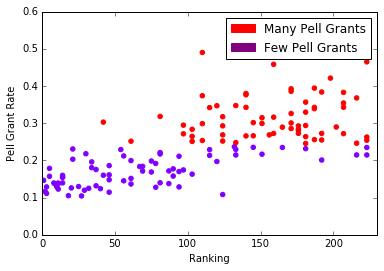

In [295]:
cmap = plt.cm.rainbow
plt.rcParams['figure.figsize'] = (6, 4)
fig, ax = plt.subplots()
ax.scatter(data['Rank'],groups['PCTPELL'], color=cmap((groups['Group'])))
ax.set_xlabel('Ranking')
ax.set_ylabel('Pell Grant Rate')
ax.set_xlim([0,230])
# ax.set_title('Relationship between Pell Grant Rate and College Ranking')
import matplotlib.patches as mpatches
col=cmap([0,1])
p0 = mpatches.Patch(color='Red', label='Many Pell Grants')
p1 = mpatches.Patch(color='Purple', label='Few Pell Grants')
plt.legend(handles =[p0, p1])

plt.show()

## Predict ##

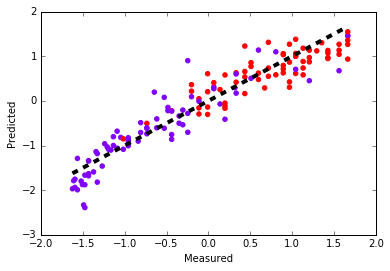

('Overall MSE: ', 0.11978610079284362)


In [296]:
lr = linear_model.LinearRegression()

# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
pred = cross_val_predict(lr, X, y, cv=10)

fig, ax = plt.subplots()
ax.scatter(y, pred, color=cmap((groups['Group'])))
minD = min(y.min(), pred.min())
maxD = max(y.max(),pred.max())
ax
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

print("Overall MSE: ",  mean_squared_error(y, pred))

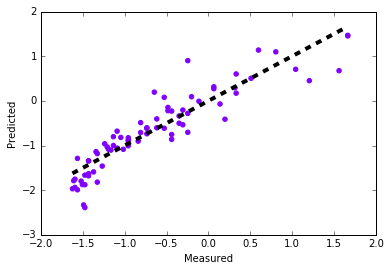

('Group0 MSE: ', 0.12758795163048015)


In [297]:
g0=np.nan_to_num(groups['Group'] == 0)
y0 = y[g0]
pred0 = pred[g0]

fig, ax = plt.subplots()
ax.scatter(y0, pred0, color=cmap((groups['Group'][g0])))
ax.plot([y0.min(), y0.max()], [y0.min(), y0.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()
print("Group0 MSE: ",  mean_squared_error(y0, pred0))

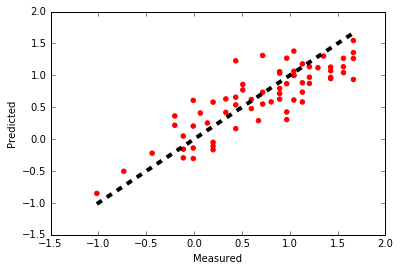

('Group1 MSE: ', 0.11105268567608625)


In [298]:
g1=np.nan_to_num(groups['Group'] == 1)
y1 = y[g1]
pred1 = pred[g1]

fig, ax = plt.subplots()
ax.scatter(y1, pred1, color=cmap((groups['Group'][g1])))
ax.plot([y1.min(), y1.max()], [y1.min(), y1.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()
print("Group1 MSE: ",  mean_squared_error(y1, pred1))

In [299]:
points1 = zip(pred1,y1)
points1.sort(key=lambda x:x[0])
points0 = zip(pred0,y0)
points0.sort(key=lambda x:x[0])


## Data ##
**X:** training data

**y:** true labels 

**pred:** predicted scores from regressor

**pred0:** predictions for group 0

**pred1:** predictions for group 1

**points:** tuple (pred_i, label_i)

**points0**

**points1**

**g:** groups indicated by [0, 1]


In [300]:
results = pd.DataFrame()
results['pred'] = pred
results['y'] = y

In [301]:
results.head()

,pred,y
0,-1.968777,-1.623478
1,-1.787749,-1.608663
2,-1.937604,-1.593848
3,-1.753451,-1.593848
4,-1.991857,-1.564218


In [302]:
def scale(df):
    return(df-df.min()) / (df.max()-df.min())

In [303]:
results.sort('pred',inplace=True)

## Binning ##
There are many different ways to bin the data:

1. Bin all data then split into groups
2. Split the data first and then bin the data

For (1) the data in each bin will be informative about the fairness of 
all data at that position in the ranking. 

However, depending on the distribution of the groups, some bins may only contain data from one group.

In this case how do we compare the error?

For (2) the data in each bin will be informative about the fairness of the position assigned to the  

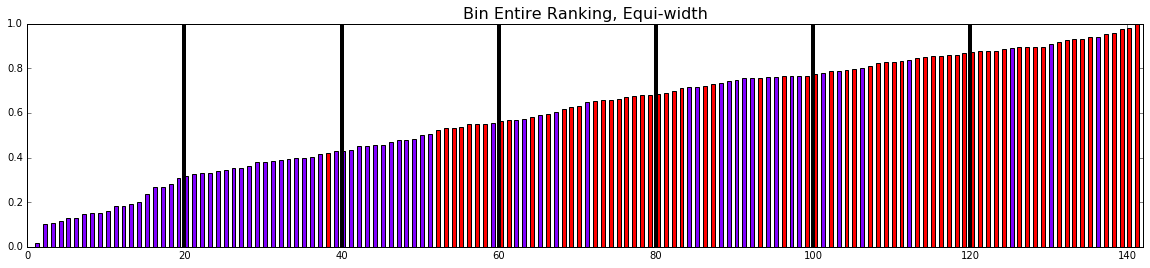

In [305]:
plt.rcParams['figure.figsize'] = (20, 4)
fig, ax = plt.subplots()
ax.bar(range(len(scaled)), scaled, 0.5,color=cmap((groups['Group'])))
ax.set_xlim([0,len(scaled)])
ax.plot([20, 20], [0, scaled.max()], 'k-', lw=4)
ax.plot([40, 40], [0, scaled.max()], 'k-', lw=4)
ax.plot([60, 60], [0, scaled.max()], 'k-', lw=4)
ax.plot([80, 80], [0, scaled.max()], 'k-', lw=4)
ax.plot([100, 100], [0, scaled.max()], 'k-', lw=4)
ax.plot([120, 120], [0, scaled.max()], 'k-', lw=4)
ax.set_title("Bin Entire Ranking, Equi-width", fontsize=16)
plt.show()

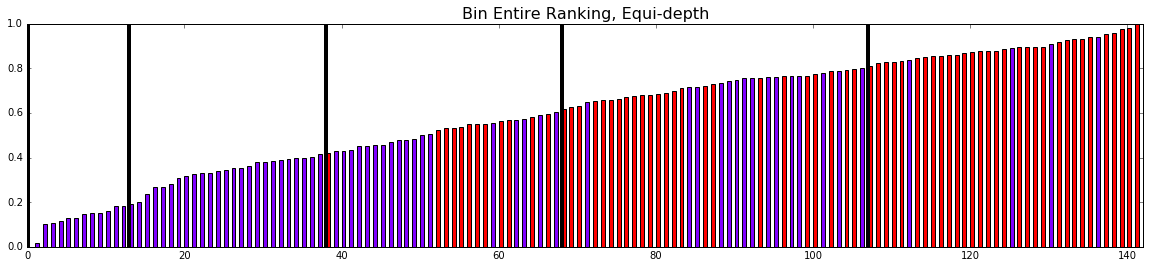

In [306]:
plt.rcParams['figure.figsize'] = (20, 4)
fig, ax = plt.subplots()
ax.bar(range(len(scaled)), scaled, 0.5,color=cmap((groups['Group'])))
ax.set_xlim([0,len(scaled)])
ax.plot([w, w], [0, scaled.max()], 'k-', lw=4)
ax.plot([13, 13], [0, 1], 'k-', lw=4)#13
ax.plot([38, 38], [0, 1], 'k-', lw=4)#38
ax.plot([68, 68], [0, 1], 'k-', lw=4)#68
ax.plot([107, 107], [0, 1], 'k-', lw=4)#107
ax.set_title("Bin Entire Ranking, Equi-depth", fontsize=16)
plt.show()

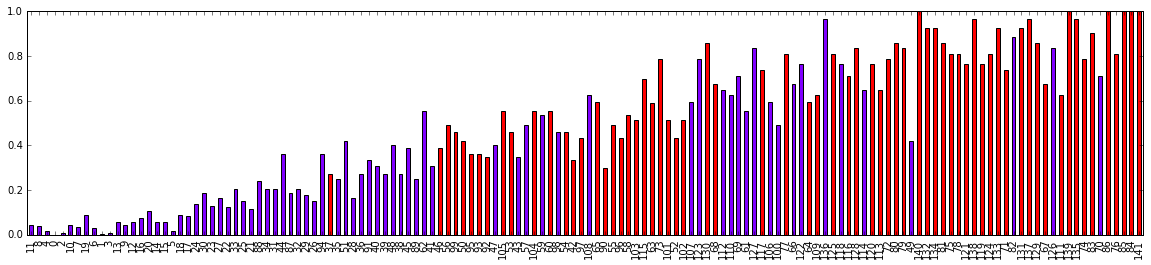

In [355]:
cmap = plt.cm.rainbow
norm = matplotlib.colors.Normalize(vmin=1.5, vmax=4.5)
plt.rcParams['figure.figsize'] = (20, 4)
scale(results['y']).plot.bar(color=cmap((groups['Group'])))

In [356]:
def get_binned_eq_depth(points, n_folds=10):
    pred = []
    y = []
    kf = KFold(len(points), n_folds=n_folds)
    print kf
    for rest, bin in kf:
        vals = [points[i] for i in bin]
        m_pred = np.mean([x[0] for x in vals])
        m_y = np.mean([x[1] for x in vals])
        pred.append([m_pred])
        y.append([m_y])
    return pred,y

def get_bin_width(data, n):
    return (data.max()-data.min())/(n+1)
    
def get_binned_eq_width(points, min_val, width, n):
    bins=[]
    b=[]
    w = min_val+width
#     c=1
    for i in range(len(points)):
        if(points[i][0] < w):
            b.append(points[i])
        else:
#             print("bin: "+str(c), b)
#             print
            m_pred = np.mean([x[0] for x in b])
            m_y = np.mean([x[1] for x in b])
            bins.append([m_pred, m_y])
            b=[]
            w+=width
#             print"w:",w
#             print
#             c+=1
    return np.asarray(bins)   

In [363]:
w = get_bin_width(pred,10)
print w
print("Group 1: ")
bins0 = get_binned_eq_width(points0, pred.min(), w, 10)
print(bins0)
print("Group 2")
bins1 = get_binned_eq_width(points1, pred.min(), w, 10)
print(bins1)

0.357919341667
Group 1: 
[[-2.36108599 -1.48273663]
 [-1.83305694 -1.51977374]
 [-1.47382899 -1.38644012]
 [-1.064222   -1.16718039]
 [-0.73989135 -0.76125359]
 [-0.40337275 -0.36174656]
 [-0.06800967 -0.28167584]
 [ 0.30616311  0.20171144]
 [ 0.66223327  0.97899706]
 [ 1.11837917  0.70245326]]
Group 2
[[        nan         nan]
 [        nan         nan]
 [        nan         nan]
 [        nan         nan]
 [        nan         nan]
 [        nan         nan]
 [-0.08093032  0.03282219]
 [ 0.32113509  0.30409849]
 [ 0.64676151  0.67097171]
 [ 1.02229641  1.24046611]]


In [358]:
# TODO: how to handle empty bin?
# can drop, or set error =0, but that is misleading
# print bins0.shape
# print bins1.shape
# bins1 = bins1[:-1]

(20, 2)
(21, 2)


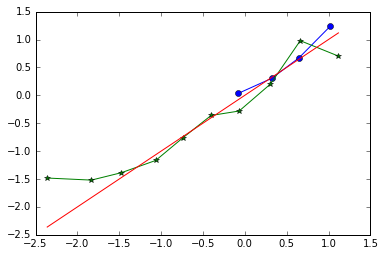

In [364]:
# reliability curve
# probem is that the regression predictions will always be much closer to the diagonal 
# than the reliability curve for the probabilistic classifier
plt.rcParams['figure.figsize'] = (6, 4)
plt.plot(bins1[:,0],bins1[:,1], marker='o')
plt.plot(bins0[:,0],bins0[:,1], marker='*')
plt.plot(bins0[:,0],bins0[:,0])
plt.show()

In [365]:
def plot_cal_error(df):
    indices =np.arange(df.shape[0])
    #Calculate optimal width
    width = 0.3

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.bar(indices-width,df['mse0'],width,color='b',label='-Ymin')
    ax.bar(indices,df['mse1'],width,color='r',label='Ymax')
    ax.set_xlim(left=-1,right=10)
    ax.set_xlabel('Bin')
    ax.set_ylabel('MSE')
    plt.show()
    
def plot_cal_norm(df):
    norm = (df-df.mean()).abs()
    
    indices =np.arange(df.shape[0])
    #Calculate optimal width
    width = 0.3
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.bar(indices-width,norm['mse0'],width,color='b',label='-Ymin')
    ax.bar(indices,norm['mse1'],width,color='r',label='Ymax')
    ax.set_xlim(left=-1,right=10)
    ax.set_xlabel('Bin')
    ax.set_ylabel('MSE')
    plt.show()



In [403]:
#These functions define the bins over each group - not over the entire ranking
def get_mse_binned_eq_width(points, min_val, width):
    bins=[]
    b=[]
    w = min_val+width
#     c=1
    for i in range(len(points)):
        if(points[i][0] < w):
            b.append(points[i])
        else:
#             print("bin: "+str(c), b)
#             print
            m = np.sum([math.pow(x[0]-x[1], 2) for x in b])
            m = m/len(b)
            bins.append(m)
            b=[]
            w+=width
#             c+=1
    return np.asarray(bins)   


def get_mse_binned_eq_depth(points, n_folds=10):
    mse = []
    kf = KFold(len(points), n_folds=n_folds)
    print kf
    for rest, bin in kf:
        vals = [points[i] for i in bin]
        m = np.sum([math.pow(x[0]-x[1], 2) for x in vals])
        m = m/len(vals)
        mse.append(m)
    return mse


Equi-width bins defined over each group


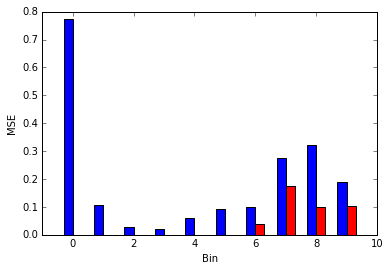

In [405]:
mse_df = pd.DataFrame()
mse_df['mse0'] = get_mse_binned_eq_width(points0,pred.min(),w)
mse_df['mse1'] = get_mse_binned_eq_width(points1,pred.min(),w)
# using equal width bins  - which one gives more comparable plot?
print
print "Equi-width bins defined over each group"
plot_cal_error(mse_df)

sklearn.cross_validation.KFold(n=75, n_folds=10, shuffle=False, random_state=None)
sklearn.cross_validation.KFold(n=67, n_folds=10, shuffle=False, random_state=None)

Equi-depth bins defined over each group


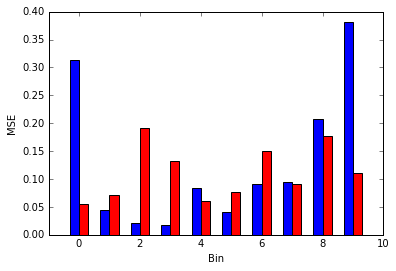

In [406]:
# using equal depth bins
mse_df['mse0'] = get_mse_binned_eq_depth(points0)
mse_df['mse1'] = get_mse_binned_eq_depth(points1)
# using equal width bins  - which one gives more comparable plot?
print
print "Equi-depth bins defined over each group"
plot_cal_error(mse_df)

## Need functions to bin over all data first, then divide each group ##

## Moving on to other metrics... ##

In [407]:
overall = pd.DataFrame()
overall['y']=y
overall['pred']=pred
overall['SE'] = pow((overall['y']-overall['pred']),2)

g0 = pd.DataFrame()
g0['y']=y0
g0['pred']=pred0
g0['SE'] = pow((g0['y']-g0['pred']),2)

g1 = pd.DataFrame()
g1['y']=y1
g1['pred']=pred1
g1['SE'] = pow((g1['y']-g1['pred']),2)

overall.sort('pred',inplace=True)
g1.sort('pred',inplace=True)
g1.sort('pred',inplace=True)

In [408]:
# histogram of error is like density estimation - maybe we use a kernel method or something

In [409]:
pd.options.display.float_format = '{:,.2f}'.format

In [410]:
#should be squared error or absolute?
def getOverUnder(df):
    diff = df['y'] - df['pred']
    df.loc[diff <0,'over'] = 0
    df.loc[diff >0,'over'] = pow(diff,2)
    df.loc[diff <0,'under'] = pow(diff,2)
    df.loc[diff >0,'under'] = 0
    df['all'] = pow(diff,2)

In [411]:
getOverUnder(overall)
print("MSE overall: ", overall['all'].mean())
print("Overestimated overall: ", overall['over'].mean())
print("Underestimated overall: ", overall['under'].mean())
print
getOverUnder(g0)
print("MSE Group 2: ", g0['all'].mean())
print("Overestimated g0: ", g0['over'].mean())
print("Underestimated g0: ", g0['under'].mean())
print
getOverUnder(g1)
print("MSE Group 1: ", g1['all'].mean())
print("Overestimated g1: ", g1['over'].mean())
print("Underestimated g1: ", g1['under'].mean())

('MSE overall: ', 0.11978610079284367)
('Overestimated overall: ', 0.07005891155625993)
('Underestimated overall: ', 0.04972718923658371)

('MSE Group 2: ', 0.12758795163048017)
('Overestimated g0: ', 0.07253878394305349)
('Underestimated g0: ', 0.05504916768742666)

('MSE Group 1: ', 0.11105268567608631)
('Overestimated g1: ', 0.06728293500387905)
('Underestimated g1: ', 0.04376975067220722)


In [412]:
print scnorm['Rank'].max()
print scnorm['Rank'].min()

1.66541829325
-1.62347767094


In [413]:
print data['Rank'].max()
print data['Rank'].min()

223
1


In [414]:
m = data['Rank'].mean()
st = data['Rank'].std()